# Машинное обучение. Алгоритм KNN

1. Загрузите данные о пассажирах Титаника. Данные можно скачать с сайта Kaggle по ссылке https://www.kaggle.com/c/titanic/data?select=train.csv или загрузить из библиотеки Seaborn командой sns.load_dataset('titanic').
2. Проверьте данные на наличие пропусков и обработайте их.
3. Если в данных присутствуют категориальные переменные, проведите их обработку.
4. Постройте алгоритм K-ближайших соседей (KNN). Для выбора оптимальных гиперпараметров используйте метод gridsearch.
5. Проверьте, насколько модель переобучена, используя кросс-валидацию.
6. Рассчитайте метрики качества модели: матрицу ошибок, accuracy, precision, recall и AUC-ROC.
7. Объясните, имеет ли смысл рассчитывать метрику MAE в данном контексте и почему.




## Установка и импорт необходимых библиотек

Загружаем:
* scikit-learn
* seaborn

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler,OneHotEncoder # шкалирование данных, нормализация

from sklearn.metrics import mean_absolute_error, mean_squared_error

## Загрузите набор данных титаник

In [ ]:
df = sns.load_dataset('titanic') # seaborn

## EDA

In [ ]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Проверьте, все ли типы данных верные. Если где-то назначен неверный тип данных, исправьте



In [ ]:
df.info?

Signature:
df.info(
    verbose: 'bool | None' = None,
    buf: 'WriteBuffer[str] | None' = None,
    max_cols: 'int | None' = None,
    memory_usage: 'bool | str | None' = None,
    show_counts: 'bool | None' = None,
) -> 'None'
Docstring:
Print a concise summary of a DataFrame.

This method prints information about a DataFrame including
the index dtype and columns, non-null values and memory usage.

Parameters
----------
verbose : bool, optional
    Whether to print the full summary. By default, the setting in
    ``pandas.options.display.max_info_columns`` is followed.
buf : writable buffer, defaults to sys.stdout
    Where to send the output. By default, the output is printed to
    sys.stdout. Pass a writable buffer if you need to further process
    the output.
max_cols : int, optional
    When to switch from the verbose to the truncated output. If the
    DataFrame has more than `max_cols` columns, the truncated output
    is used. By default, the setting in
    ``pandas.options

In [ ]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


Вывод: все типы назначены верно



### Проверка на пропуски



In [ ]:
df_null = df.isna().mean().sort_values() # NaN
df_null

survived       0.000000
pclass         0.000000
sex            0.000000
sibsp          0.000000
parch          0.000000
fare           0.000000
class          0.000000
who            0.000000
adult_male     0.000000
alive          0.000000
alone          0.000000
embarked       0.002245
embark_town    0.002245
age            0.198653
deck           0.772166
dtype: float64

In [ ]:
df_null = df.isna().mean().sort_values()
features_null = list(df_null[df_null>0].index)
features_null

['embarked', 'embark_town', 'age', 'deck']

Вывод: 4 переменные содержат пропуски: embarked, embark_town, age, deck



### Анализ категориальных переменных



сколько категориальных признаков

In [ ]:
features_cat = list(df.select_dtypes(exclude='number').columns)
features_cat

['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

Посмотрите на значения категориальных признаков

In [ ]:
for col in features_cat:
  print(f'col={col}')
  print(df[col].value_counts(normalize=True))

col=sex
sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64
col=embarked
embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64
col=class
class
Third     0.551066
First     0.242424
Second    0.206510
Name: proportion, dtype: float64
col=who
who
man      0.602694
woman    0.304153
child    0.093154
Name: proportion, dtype: float64
col=adult_male
adult_male
True     0.602694
False    0.397306
Name: proportion, dtype: float64
col=deck
deck
C    0.290640
B    0.231527
D    0.162562
E    0.157635
A    0.073892
F    0.064039
G    0.019704
Name: proportion, dtype: float64
col=embark_town
embark_town
Southampton    0.724409
Cherbourg      0.188976
Queenstown     0.086614
Name: proportion, dtype: float64
col=alive
alive
no     0.616162
yes    0.383838
Name: proportion, dtype: float64
col=alone
alone
True     0.602694
False    0.397306
Name: proportion, dtype: float64


In [ ]:
df.groupby(['who', 'adult_male'], as_index=False).survived.count()

,who,adult_male,survived
0,child,False,83
1,man,True,537
2,woman,False,271


>в модели дальше будем использовать переменную who, которая по сути повторяет переменную adult_male

In [ ]:
df.groupby(['alive', 'survived'], as_index=False).sex.count()

,alive,survived,sex
0,no,0,549
1,yes,1,342


'alive', 'survived' дублируют

In [ ]:
df.groupby(['embarked', 'embark_town'], as_index=False).sex.count()

,embarked,embark_town,sex
0,C,Cherbourg,168
1,Q,Queenstown,77
2,S,Southampton,644


'embarked', 'embark_town' дублируют

In [ ]:
features_cat.remove('adult_male')

In [ ]:
features_cat.remove('alive')

In [ ]:
features_cat.remove('embark_town')
features_null.remove('embark_town')

In [ ]:
features_cat.remove('deck')
features_null.remove('deck')

In [ ]:
features_cat

['sex', 'embarked', 'class', 'who', 'alone']

In [ ]:
features_number = list(df.select_dtypes(include='number').columns)
features_number

['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']

In [ ]:
target = 'survived'

Какие категориальные признаки будем использовать в модели?

><font color='green'>Вывод:
Далее будем использовать:
 'sex', 'embarked', 'class', 'who', 'deck', 'alone'</font>



## Разделим выборку на тренировочную и тестовую

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df[features_cat+features_number],
                                                    df[target],
                                                    stratify=df[target],
                                                    test_size=0.2, random_state=42)


In [ ]:
X_train.shape,  X_test.shape

((712, 11), (179, 11))

In [ ]:
y_train.mean(), y_test.mean()

(0.38342696629213485, 0.3854748603351955)

## Подготовка датасета к построению моделей

### Обработка пропусков



In [ ]:
features_null

['embarked', 'age']

In [ ]:
for col in features_null:
  if col in features_cat:
    print(f'col={col} replace {X_train[col].mode()}') # по моде
    X_train[col] = X_train[col].fillna(X_train[col].mode())
    X_test[col] = X_test[col].fillna(X_train[col].mode())
  else:
    print(f'col={col} replace {X_train[col].mean()}') # по среднему
    X_test[col] = X_test[col].fillna(X_train[col].mean())
    X_train[col] = X_train[col].fillna(X_train[col].mean())


col=embarked replace 0    S
Name: embarked, dtype: object
col=age replace 29.807686956521735


### Обработка категориальных признаков



In [ ]:
X_train = pd.get_dummies(X_train, columns=features_cat, drop_first=True)
X_test = pd.get_dummies(X_test, columns=features_cat, drop_first=True)

In [ ]:
X_train

,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman,alone_True
692,1,3,29.807687,0,0,56.4958,True,False,True,False,True,True,False,True
481,0,2,29.807687,0,0,0.0000,True,False,True,True,False,True,False,True
527,0,1,29.807687,0,0,221.7792,True,False,True,False,False,True,False,True
855,1,3,18.000000,0,1,9.3500,False,False,True,False,True,False,True,False
801,1,2,31.000000,1,1,26.2500,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1,3,29.807687,0,0,7.8792,False,True,False,False,True,False,True,True
258,1,1,35.000000,0,0,512.3292,False,False,False,False,False,False,True,True
736,0,3,48.000000,1,3,34.3750,False,False,True,False,True,False,True,False
462,0,1,47.000000,0,0,38.5000,True,False,True,False,False,True,False,True


><font color='green'>**Вывод:  применила OneHotEncoding для простоты**</font>



## Построение модели

<font color='1A9BFF'>**1. Задайте сетку параметров для параметров: n_neighbors, p**</font>   
<font color='1A9BFF'>**2. С помощью gridsearch выберите наилучшие параметры n_neighbors, p**</font>   
<font color='1A9BFF'>**3. С помощью кросс-валидации убедитесь, что модель с минимальным переобучением**</font>



GridSearchCV позволяет провести решетчатый поиск по заданным наборам гиперпараметров.

In [ ]:
param_grid = {'n_neighbors': range(1, 21, 5),
              'p': [1, 2]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
             scoring='roc_auc')

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007689,0.001304,0.009869,0.001316,1,1,"{'n_neighbors': 1, 'p': 1}",0.813636,0.796591,0.877011,0.817130,0.835648,0.828003,0.027465,5
1,0.007284,0.001256,0.009072,0.003025,1,2,"{'n_neighbors': 1, 'p': 2}",0.732955,0.713636,0.781296,0.712542,0.759470,0.739980,0.026769,8
2,0.008410,0.002056,0.010852,0.001340,6,1,"{'n_neighbors': 6, 'p': 1}",0.857851,0.897314,0.905643,0.929714,0.890152,0.896135,0.023327,2
3,0.008048,0.001807,0.009587,0.002353,6,2,"{'n_neighbors': 6, 'p': 2}",0.787603,0.808161,0.851306,0.880471,0.827652,0.831039,0.032483,4
4,0.007323,0.001435,0.010486,0.003123,11,1,"{'n_neighbors': 11, 'p': 1}",0.851343,0.906715,0.908882,0.926031,0.898674,0.898329,0.025127,1
5,0.006532,0.001154,0.007395,0.001416,11,2,"{'n_neighbors': 11, 'p': 2}",0.789256,0.799897,0.803030,0.894465,0.818708,0.821071,0.037890,6
6,0.007638,0.001259,0.009063,0.002344,16,1,"{'n_neighbors': 16, 'p': 1}",0.835537,0.891322,0.916719,0.926557,0.889099,0.891847,0.031629,3
7,0.007763,0.001393,0.008874,0.002355,16,2,"{'n_neighbors': 16, 'p': 2}",0.790599,0.783471,0.792581,0.873737,0.815657,0.811209,0.033078,7


In [ ]:
grid_search.best_params_

{'n_neighbors': 11, 'p': 1}

In [ ]:
knn_best = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11, p=1)

><font color='green'>**Вывод:  'n_neighbors': 11, 'p': 1**</font>



## Оценка качества финальной модели

### Посчитайте метрики качества: матрицу ошибок, accuracy, precision, recall, AUC ROC  

In [ ]:
y_test_pred = knn_best.predict(X_test)
y_test_prob = knn_best.predict_proba(X_test)[:, 1]

y_train_pred = knn_best.predict(X_train)
y_train_prob = knn_best.predict_proba(X_train)[:, 1]

In [ ]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix Test:")
print(conf_matrix)

conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix Train:")
print(conf_matrix)


Confusion Matrix Test:
[[94 16]
 [18 51]]
Confusion Matrix Train:
[[396  43]
 [ 52 221]]


In [ ]:

# Accuracy

print("Accuracy:", accuracy_score(y_test, y_test_pred), accuracy_score(y_train, y_train_pred))

# Precision
print("Precision:", precision_score(y_test, y_test_pred), precision_score(y_train, y_train_pred))

# Recall
print("Recall:", recall_score(y_test, y_test_pred), recall_score(y_train, y_train_pred))


Accuracy: 0.8100558659217877 0.8665730337078652
Precision: 0.7611940298507462 0.8371212121212122
Recall: 0.7391304347826086 0.8095238095238095


In [ ]:

# AUC ROC
print("AUC ROC:", roc_auc_score(y_train, y_train_prob), roc_auc_score(y_test, y_test_prob))

AUC ROC: 0.9330354535365925 0.8741765480895916


### Постройте график ROC кривой

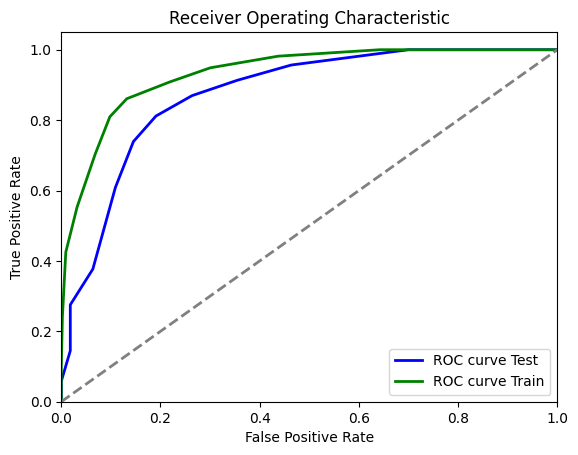

In [ ]:
import matplotlib.pyplot as plt
# Построение ROC кривой
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve Test')

fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve Train')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()